# Calibration Diagnostic

In [ ]:
# Defaults overwritten on cmd line
observation = None
cmp_observation = None
settings = ""
cmp_settings = ""
global_config = {}

In [ ]:
%matplotlib inline
import warnings
from datetime import datetime
from pathlib import Path

import edges.io as eio
import matplotlib.pyplot as plt
from beautifultable import BeautifulTable
from matplotlib.lines import Line2D

from edges import cal as ec
from edges.cal.config import config

This document compares two observations:

In [ ]:
config.update(global_config)
calobs = ec.CalibrationObservation.from_yaml(settings, obs_path=observation)
calobs_cmp = ec.CalibrationObservation.from_yaml(cmp_settings, obs_path=cmp_observation)
io_obs = calobs.metadata["io"]
io_cmp = calobs_cmp.metadata["io"]

In [6]:
obspath = Path(io_obs.original_path).absolute()
cmppath = Path(io_cmp.original_path).absolute()
print("Primary Location   : ", obspath)
print("Comparison Location: ", cmppath)
print()

print("Date Run: ", datetime.now())
print("Version of edges-io:", eio.__version__)
print("Version of edges-cal:", ec.__version__)

Primary Location   :  /data5/edges/data/CalibrationObservations/Receiver01/Receiver01_25C_2019_10_01_040_to_200MHz
Comparison Location:  /data5/edges/data/CalibrationObservations/Receiver01/Receiver01_25C_2019_11_26_040_to_200MHz

Date Run:  2020-12-14 15:12:43.565032
Version of edges-io: 0.0.post0.dev1+g97f97d7
Version of edges-cal: 0.0.post0.dev1+g319afab


In [8]:
simnames = io_obs.simulator_names.intersection(io_cmp.simulator_names)
antsims = {name: calobs.new_load(name, io_obj=io_obs) for name in simnames}
antsims_cmp = {name: calobs_cmp.new_load(name, io_obj=io_cmp) for name in simnames}

## Observation Metadata

The following metadata fully defines this calibration for this version of `edges-cal`:

In [23]:
def print_summary(calobs, io_obs):
    table = BeautifulTable()
    table.rows.append(["wterms", calobs.wterms, "cterms", calobs.cterms])
    table.rows.append(
        ["f_min", f"{calobs.freq.min:.2f} MHz", "f_max", f"{calobs.freq.max:.2f} MHz"]
    )
    table.rows.append(
        [
            "Ext. Calkit (rcv) Match Res.",
            f"{calobs.receiver.metadata['calkit'].match.resistance} Ohms",
            "Int. Calkit Match Res.",
            f"{calobs.internal_switch.metadata['calkit'].match.resistance} Ohms",
        ]
    )
    table.rows.append(["Receiver S11 nterms", calobs.receiver.n_terms, "", ""])
    print(table)
    print()

    table = BeautifulTable()
    table.columns.header = [
        "S11 Run",
        "Spec/Res. Run",
        "S11 Rep.",
        "Ignored %",
        "S11 nterms",
    ]
    sources = []
    for name, source in calobs.loads.items():
        sources.append(name)
        table.rows.append(
            [
                io_obs.s11.run_num[name],
                io_obs.spectra.run_num[name],
                io_obs.s11.repeat_num[name],
                source.spectrum.metadata["ignore_times_percent"],
                source.reflections.n_terms,
            ]
        )
    table.rows.header = sources
    print(table)

    print()
    print("Antenna Simulators Available:", ", ".join(sorted(io_obs.simulator_names)))

In [24]:
print("Primary Observation:", obspath.name)
print("=====================" + "=" * len(obspath.name))
print_summary(calobs, io_obs)

Primary Observation: Receiver01_25C_2019_10_01_040_to_200MHz
> Compiled from empty definition file. Does not include data from previous observations.

+----------+-------------+----------------+------------+
|  wterms  |      7      |     cterms     |     7      |
+----------+-------------+----------------+------------+
|  f_min   |  40.00 MHz  |     f_max      | 199.99 MHz |
+----------+-------------+----------------+------------+
| LNA Res. | 50.009 Ohms | LNA S11 nterms |     37     |
+----------+-------------+----------------+------------+

+-------+-------+-----------+-------+--------+----------------+---------+------+
|       | S11 R | Spec/Res. | S11 R | Ignore | Male Res. (Ohm | S11 nte | xRFI |
|       |  un   |    Run    |  ep.  |  d %   |       s)       |   rms   |      |
+-------+-------+-----------+-------+--------+----------------+---------+------+
| ambie |   2   |     1     |   1   |  5.0   |     50.166     |   37    | 1D2D |
|  nt   |       |           |       |       

In [25]:
print("Comparison Observation:", cmppath.name)
print("========================" + "=" * len(cmppath.name))
print_summary(calobs_cmp, io_cmp)

Comparison Observation: Receiver01_25C_2019_11_26_040_to_200MHz
> Compiled from empty definition file. Does not include data from previous observations.

+----------+-------------+----------------+------------+
|  wterms  |      7      |     cterms     |     7      |
+----------+-------------+----------------+------------+
|  f_min   |  40.00 MHz  |     f_max      | 199.99 MHz |
+----------+-------------+----------------+------------+
| LNA Res. | 50.009 Ohms | LNA S11 nterms |     37     |
+----------+-------------+----------------+------------+

+-------+-------+-----------+-------+--------+----------------+---------+------+
|       | S11 R | Spec/Res. | S11 R | Ignore | Male Res. (Ohm | S11 nte | xRFI |
|       |  un   |    Run    |  ep.  |  d %   |       s)       |   rms   |      |
+-------+-------+-----------+-------+--------+----------------+---------+------+
| ambie |   2   |     1     |   1   |  5.0   |     50.166     |   37    | 1D2D |
|  nt   |       |           |       |    

In [12]:
print(
    "Antenna Simulators available in both observations: ", ", ".join(sorted(simnames))
)

Antenna Simulators available in both observations:  AntSim2, AntSim3


## Raw Data

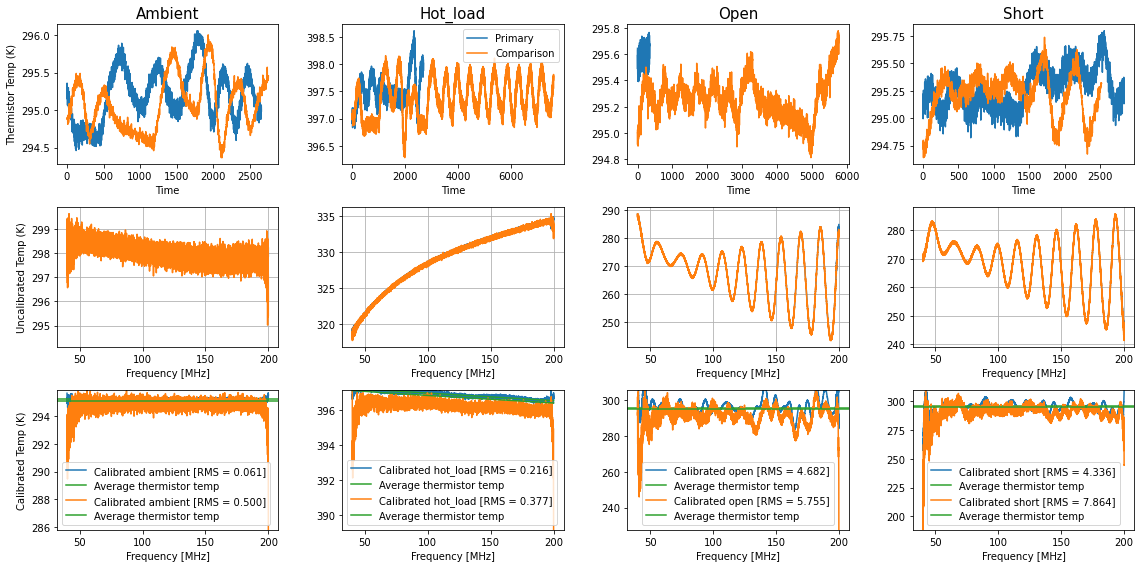

In [ ]:
fig, ax = plt.subplots(
    3,
    4,
    figsize=(16, 8),
    # gridspec_kw={"hspace":0.05, 'wspace':0.05}
)

for i, (name, load) in enumerate(calobs.loads.items()):
    ec.plots.plot_resistance_measurements(io_obs.resistance._loads[name], ax=ax[0, i])
    ec.plots.plot_resistance_measurements(io_cmp.resistance._loads[name], ax=ax[0, i])

    ax[0, i].set_title(name.capitalize(), fontsize=15)
    ax[0, i].set_xlabel("Time")

    ec.plots.plot_raw_spectrum(
        load.spectrum, fig=fig, ax=ax[1, i], ylabel=False, xlabel=False
    )
    ec.plots.plot_raw_spectrum(
        calobs_cmp.loads[name].spectrum,
        fig=fig,
        ax=ax[1, i],
        ylabel=False,
        xlabel=False,
    )

    calobs.plot_calibrated_temp(load, ax=ax[2, i], ylabel=False)
    calobs.plot_calibrated_temp(calobs_cmp.loads[name], ax=ax[2, i], ylabel=False)

ax[0, 0].set_ylabel("Thermistor Temp (K)")
ax[1, 0].set_ylabel("Uncalibrated Temp (K)")
ax[2, 0].set_ylabel("Calibrated Temp (K)")
ax[0, 1].legend()
plt.tight_layout()

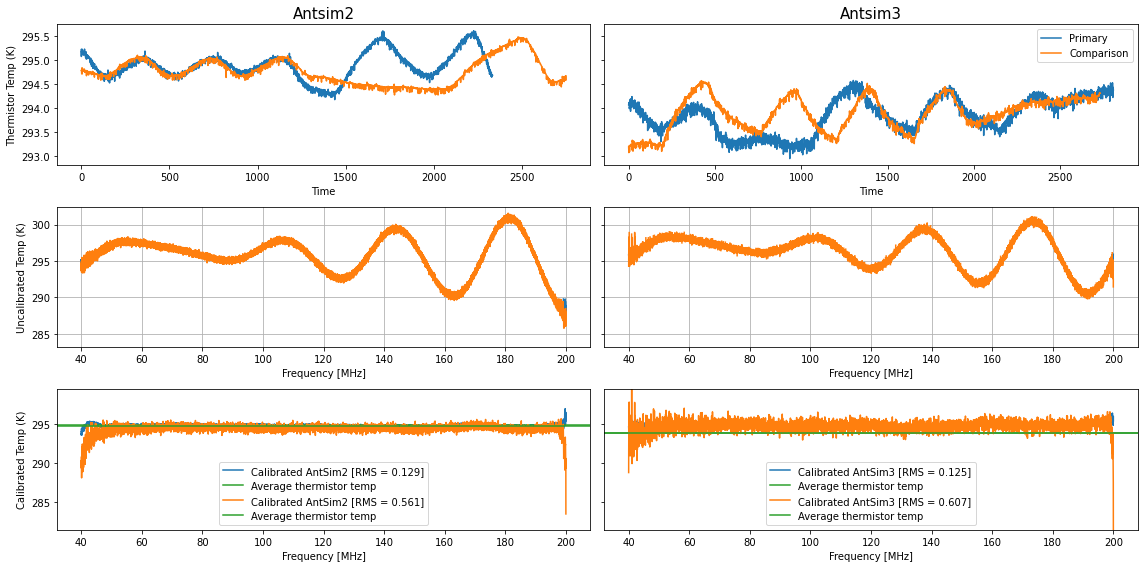

In [ ]:
fig, ax = plt.subplots(3, len(antsims), figsize=(16, 8), sharey="row", squeeze=False)

for i, (name, load) in enumerate(antsims.items()):
    ec.plots.plot_resistance_measurements(
        io_obs.resistance.simulators[name], ax=ax[0, i]
    )
    ec.plots.plot_resistance_measurements(
        io_cmp.resistance.simulators[name], ax=ax[0, i]
    )

    ax[0, i].set_title(name.capitalize(), fontsize=15)
    ax[0, i].set_xlabel("Time")

    ec.plots.plot_raw_spectrum(
        load.spectrum, fig=fig, ax=ax[1, i], ylabel=False, xlabel=False
    )
    ec.plots.plot_raw_spectrum(
        antsims_cmp[name].spectrum, fig=fig, ax=ax[1, i], ylabel=False, xlabel=False
    )

    calobs.plot_calibrated_temp(load, ax=ax[2, i], ylabel=False)
    calobs_cmp.plot_calibrated_temp(antsims_cmp[name], ax=ax[2, i], ylabel=False)

ax[0, 0].set_ylabel("Thermistor Temp (K)")
ax[1, 0].set_ylabel("Uncalibrated Temp (K)")
ax[2, 0].set_ylabel("Calibrated Temp (K)")
ax[0, 0].legend()
plt.tight_layout()

## S11

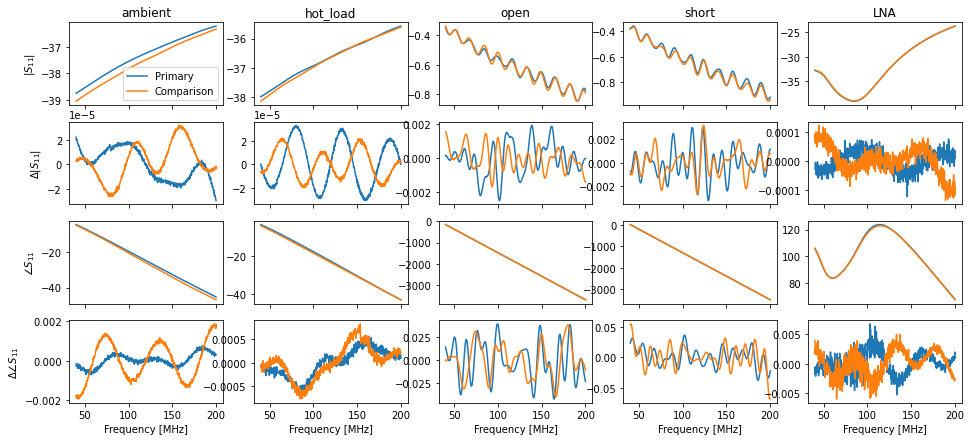

In [15]:
fig, ax = plt.subplots(4, 5, sharex=True, figsize=(16, 7))
warnings.filterwarnings("ignore", category=DeprecationWarning)

for i, (name, source) in enumerate(calobs.loads.items()):
    source.reflections.plot_residuals(
        fig=fig,
        ax=ax[:, i],
        title=False,
        decade_ticks=False,
        ylabels=not i,
        color_abs="C0",
        color_diff="C0",
        label="Primary" if not i else None,
    )
    calobs_cmp.loads[name].reflections.plot_residuals(
        fig=fig,
        ax=ax[:, i],
        title=False,
        decade_ticks=False,
        ylabels=not i,
        color_abs="C1",
        color_diff="C1",
        label="Comparison" if not i else None,
    )
    ax[0, i].set_title(name)

calobs.receiver.plot_residuals(
    fig=fig,
    ax=ax[:, -1],
    title=False,
    decade_ticks=False,
    ylabels=False,
    color_abs="C0",
    color_diff="C0",
)
calobs_cmp.receiver.plot_residuals(
    fig=fig,
    ax=ax[:, -1],
    title=False,
    decade_ticks=False,
    ylabels=False,
    color_abs="C1",
    color_diff="C1",
)

ax[0, -1].set_title("LNA");

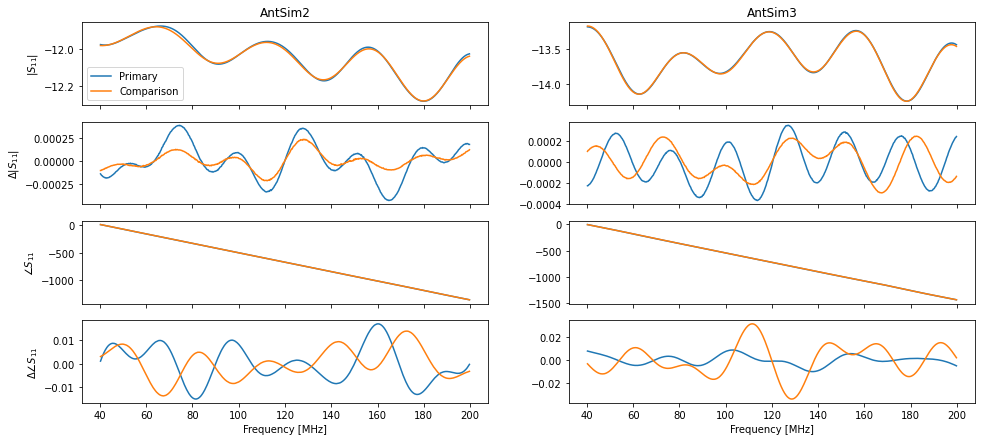

In [16]:
fig, ax = plt.subplots(4, len(antsims), sharex=True, figsize=(16, 7), squeeze=False)
warnings.filterwarnings("ignore", category=DeprecationWarning)

for i, (name, source) in enumerate(antsims.items()):
    source.reflections.plot_residuals(
        fig=fig,
        ax=ax[:, i],
        title=False,
        decade_ticks=False,
        ylabels=not i,
        color_abs="C0",
        color_diff="C0",
        label="Primary" if not i else None,
    )
    antsims_cmp[name].reflections.plot_residuals(
        fig=fig,
        ax=ax[:, i],
        title=False,
        decade_ticks=False,
        ylabels=not i,
        color_abs="C1",
        color_diff="C1",
        label="Comparison" if not i else None,
    )
    ax[0, i].set_title(name)

## Calibration

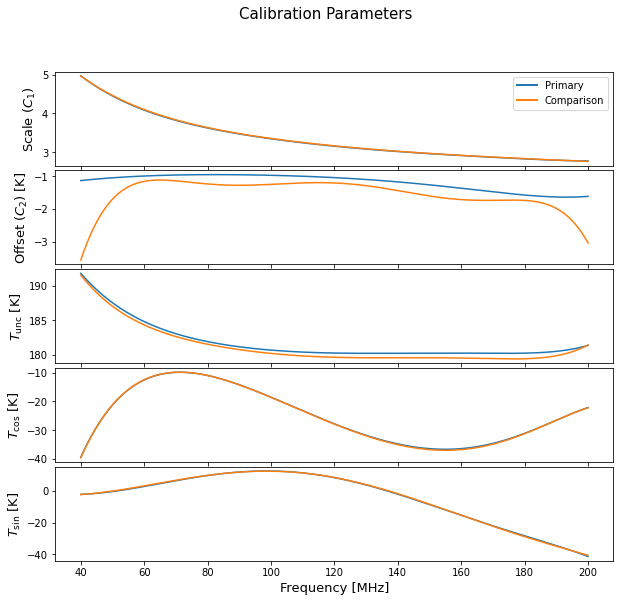

In [17]:
fig = calobs.plot_coefficients()
ax = fig.axes
calobs_cmp.plot_coefficients(fig=fig, ax=ax)
lines = [Line2D([0], [0], color=f"C{i}", linewidth=2, linestyle="-") for i in range(2)]
labels = ["Primary", "Comparison"]
ax[0].legend(lines, labels);

## List of All Files Used

In [18]:
import os


def list_files(startpath, filter_list):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(str(startpath), "").count(os.sep)
        indent = " " * 4 * (level)
        ff = [
            f
            for f in files
            if any(str(x).startswith(str(Path(root) / f)) for x in filter_list)
        ]
        dd = [
            d
            for d in dirs
            if any(str(x).startswith(str(Path(root) / d)) for x in filter_list)
        ]
        if ff or dd:
            print(f"{indent}{os.path.basename(root)}/")
        if ff:
            subindent = " " * 4 * (level + 1)
            for f in sorted(ff):
                print(f"{subindent}{f}")

In [19]:
fl = io_obs.list_of_files[0]
print("Primary Observation")
print("===================")
list_files(obspath.parent, io_obs.list_of_files)

Primary Observation
tmp5_tkp7m1/
    Receiver01_25C_2019_10_01_040_to_200MHz/
        Spectra/
            Ambient_01_2019_274_00_15_30_lab.acq
            HotLoad_01_2019_275_00_00_35_lab.acq
            LongCableOpen_01_2019_276_21_56_00_lab.acq
            LongCableOpen_01_2019_277_00_00_30_lab.acq
            LongCableOpen_01_2019_278_00_00_29_lab.acq
            LongCableOpen_01_2019_279_00_00_27_lab.acq
            LongCableOpen_01_2019_280_00_00_26_lab.acq
            LongCableShorted_01_2019_287_18_31_06_lab.acq
            LongCableShorted_01_2019_288_00_00_07_lab.acq
        Resistance/
            Ambient_01_2019_273_17_15_41_lab.csv
            HotLoad_01_2019_274_17_00_51_lab.csv
            LongCableOpen_01_2019_276_11_14_44_lab.csv
            LongCableShorted_02_2019_287_11_31_14_lab.csv
        S11/
            Ambient01/
                External02.s1p
                Match02.s1p
                Open02.s1p
                Short02.s1p
            LongCableShorted01/
   

In [20]:
fl = io_cmp.list_of_files[0]
print("Comparison Observation")
print("======================")
list_files(cmppath.parent, io_cmp.list_of_files)

Comparison Observation
tmpav79g0ug/
    Receiver01_25C_2019_11_26_040_to_200MHz/
        Spectra/
            Ambient_01_2019_329_23_01_16_lab.acq
            Ambient_01_2019_330_00_00_00_lab.acq
            HotLoad_01_2019_330_23_38_05_lab.acq
            HotLoad_01_2019_331_00_00_23_lab.acq
            HotLoad_01_2019_332_00_00_34_lab.acq
            HotLoad_01_2019_333_00_00_01_lab.acq
            LongCableOpen_01_2019_334_18_43_21_lab.acq
            LongCableOpen_01_2019_335_00_00_06_lab.acq
            LongCableOpen_01_2019_336_00_00_16_lab.acq
            LongCableShorted_01_2019_333_20_17_28_lab.acq
            LongCableShorted_01_2019_334_00_00_32_lab.acq
        Resistance/
            Ambient_01_2019_329_16_02_35_lab.csv
            HotLoad_01_2019_330_16_38_16_lab.csv
            LongCableOpen_01_2019_334_11_43_15_lab.csv
            LongCableShorted_01_2019_333_13_17_29_lab.csv
        S11/
            Ambient01/
                External02.s1p
                Match02.s1p
 